# COMPUTER VISION AND PATTERN RECOGNITION PROJECT
## Alessandro Cesa

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import copy

In [2]:
np.random.seed(0)
torch.manual_seed(0)


In [3]:
!wget -c https://github.com/AlessandroCesaTs/Computer_Vision_Project_Cesa/archive/main.zip
!unzip main.zip

--2023-12-26 13:33:12--  https://github.com/AlessandroCesaTs/Computer_Vision_Project_Cesa/archive/main.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/AlessandroCesaTs/Computer_Vision_Project_Cesa/zip/refs/heads/main [following]
--2023-12-26 13:33:12--  https://codeload.github.com/AlessandroCesaTs/Computer_Vision_Project_Cesa/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [           <=>      ] 164.35M  34.2MB/s    in 5.1s    

2023-12-26 13:33:20 (32.5 MB/s) - ‘main.zip’ saved [172336422]

Archive:  main.zip
038710216bde8c01158c6241a5d4f397e65dc1b2
   creating

In [4]:
train_path = "Computer_Vision_Project_Cesa-main/CVPR2023_project_2_and_3_data/train"
test_path = "Computer_Vision_Project_Cesa-main/CVPR2023_project_2_and_3_data/test"

In [5]:
transform=transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),transforms.Grayscale()])

In [6]:
train=ImageFolder(root=train_path,transform=transform)
test=ImageFolder(root=test_path,transform=transform)

In [7]:

# check the dataset size
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")
print(train.classes)


Train size: 1500
Test size: 2985
['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


label: 0
class: Bedroom


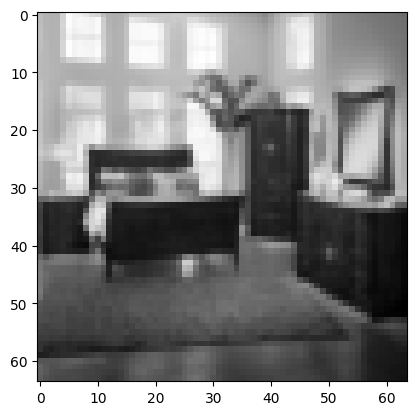

In [8]:
# get image no. 1 and its label
index=1
img,label=train[index]

print(f"label: {label}")

print("class: " + train.classes[label])
# display
figure = plt.figure()
plt.imshow(img.numpy().transpose((1, 2, 0)),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)

In [9]:
#split training set into training and validation
train_size=int(0.85*len(train))
validation_size=len(train)-train_size
training_set,validation_set=torch.utils.data.random_split(train,[train_size,validation_size])

In [10]:
# Create data loaders.
# Data loaders are basically objects that make easy to iterate through the data by batches of some batch_size

batch_size = 32
train_loader = DataLoader(training_set, batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size,shuffle=False)

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# get a batch from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)   #images is a (batch_size,3,32,32) tensor

print(images.size())


Shape of X [N, C, H, W]: torch.Size([32, 1, 64, 64])
Shape of y: torch.Size([32]) torch.int64
torch.Size([32, 1, 64, 64])


torch.Size([32, 1, 64, 64])
Store Suburb Mountain LivingRoom Forest Mountain Highway Industrial Street Industrial Office Highway Forest Forest Mountain Street Suburb Street Coast Bedroom LivingRoom InsideCity InsideCity Mountain Store Office Kitchen Bedroom Mountain Industrial LivingRoom TallBuilding


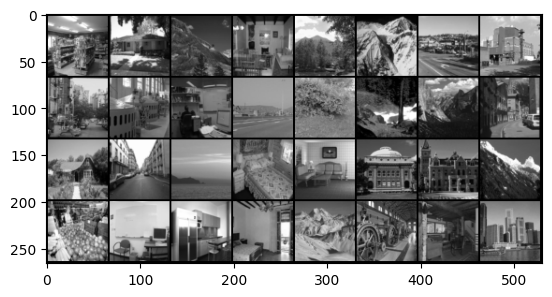

In [11]:
classes=train.classes

# get a batch from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)   #images is a (batch_size,3,32,32) tensor

print(images.size())

img=torchvision.utils.make_grid(images)
figure = plt.figure()
plt.imshow(img.numpy().transpose((1, 2, 0)),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


TallBuilding


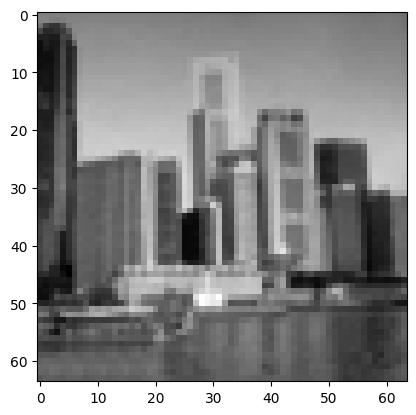

In [12]:

# display the last image only
figure = plt.figure()
plt.imshow(images[-1,:,:,:].numpy().transpose((1,2,0)),cmap='gray')
print(f'{train.classes[labels[-1]]:5s}')


In [13]:
#build the network

class simpleCNN(nn.Module):
  def __init__(self):
    super(simpleCNN,self).__init__() #initialize the model

    self.conv1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1) #Output image size is (size+2*padding-kernel)/stride -->62*62
    self.relu1=nn.ReLU()
    self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2) #outtput image 62/2-->31*31

    self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1) #output image is 29*29
    self.relu2=nn.ReLU()
    self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=2) #output image is 29/2-->14*14  (MaxPool2d approximates size with floor)

    self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1) #output image is 12*12
    self.relu3=nn.ReLU()

    self.fc1=nn.Linear(32*12*12,15) #16 channels * 16*16 image (64*64 with 2 maxpooling of stride 2), 15 output features=15 classes
    self.softmax = nn.Softmax(dim=1)

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu1(x)
    x=self.maxpool1(x)

    x=self.conv2(x)
    x=self.relu2(x)
    x=self.maxpool2(x)

    x=self.conv3(x)
    x=self.relu3(x)

    x=x.view(-1,32*12*12)

    x=self.fc1(x)
    x=self.softmax(x)

    return x



In [14]:
def init_weights(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear):
    nn.init.normal_(m.weight,0,0.01)
    #nn.init.kaiming_normal_(m.weight)
    nn.init.zeros_(m.bias)

In [15]:

# Instantiate the model
model = simpleCNN()

model.apply(init_weights)
# Print the model summary
print(model)


simpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (fc1): Linear(in_features=4608, out_features=15, bias=True)
  (softmax): Softmax(dim=1)
)


In [16]:
#Training
loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
#optimizer = optim.Adam(model.parameters())

def train_one_epoch(epoch_index,loader):
  running_loss=0

  for i, data in enumerate(loader):

    inputs,labels=data #get the minibatch
    outputs=model(inputs) #forward pass

    loss=loss_function(outputs,labels) #compute loss
    running_loss+=loss.item() #sum up the loss for the minibatches processed so far

    optimizer.zero_grad() #reset gradients
    loss.backward() #compute gradient
    optimizer.step() #update weights

  return running_loss/(i+1) # average loss per minibatch


In [17]:

EPOCHS=50

best_validation_loss=np.inf

for epoch in range(EPOCHS):
  print('EPOCH{}:'.format(epoch+1))

  model.train(True)
  train_loss=train_one_epoch(epoch,train_loader)

  running_validation_loss=0.0

  model.eval()

  with torch.no_grad(): # Disable gradient computation and reduce memory consumption
    for i,vdata in enumerate(validation_loader):
      vinputs,vlabels=vdata
      voutputs=model(vinputs)
      vloss=loss_function(voutputs,vlabels)
      running_validation_loss+=vloss
  validation_loss=running_validation_loss/(i+1)
  print('LOSS train: {} validation: {}'.format(train_loss,validation_loss))

  if validation_loss<best_validation_loss: #save the model if it's the best so far
    timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')
    best_validation_loss=validation_loss
    model_path='model_{}_{}'.format(timestamp,epoch)
    torch.save(model.state_dict(),model_path)


EPOCH1:
LOSS train: 2.708055454492569 validation: 2.7080559730529785
EPOCH2:
LOSS train: 2.708052861690521 validation: 2.7080631256103516
EPOCH3:
LOSS train: 2.7080483734607697 validation: 2.7080819606781006
EPOCH4:
LOSS train: 2.7080475270748137 validation: 2.7080938816070557
EPOCH5:
LOSS train: 2.7080454349517824 validation: 2.708095073699951
EPOCH6:
LOSS train: 2.708043873310089 validation: 2.7081050872802734
EPOCH7:
LOSS train: 2.7080427050590514 validation: 2.7081358432769775
EPOCH8:
LOSS train: 2.708039474487305 validation: 2.7081339359283447
EPOCH9:
LOSS train: 2.7080377340316772 validation: 2.7081360816955566
EPOCH10:
LOSS train: 2.7080356657505034 validation: 2.7081518173217773
EPOCH11:
LOSS train: 2.7080359756946564 validation: 2.708165168762207
EPOCH12:
LOSS train: 2.708031290769577 validation: 2.7081716060638428
EPOCH13:
LOSS train: 2.7080311596393587 validation: 2.7081727981567383
EPOCH14:
LOSS train: 2.708028680086136 validation: 2.7081892490386963
EPOCH15:
LOSS train: 2.

In [18]:

#load the best model and evaluate performance on the test set

newModel=simpleCNN()
newModel.load_state_dict(torch.load(model_path))

correct=0
total=0

with torch.no_grad():
  for data in test_loader:
    images,labels=data
    outputs=newModel(images)
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

print(f"Accuracy of the network on the test images: {100*correct/total}%")


Accuracy of the network on the test images: 7.068676716917923%
